## Librerias 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from lib.LCWavelet import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Arquitectura del modelo

In [2]:
class ShallueModel(nn.Module):
    def __init__(self, global_size=2001, local_size=201, num_classes=2):
        super(ShallueModel, self).__init__()
        self.global_size = global_size
        self.local_size = local_size
        self.num_classes = num_classes
        if num_classes == 1:
            print("Binary classification, sigmoid activation will be used.")
        elif num_classes > 1:
            print("Multi-class classification, softmax activation will be used.")
            
        
        self.conv_global_avg = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(64, 128, 5),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(128, 256, 5),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
        )
        
        self.conv_global_diff = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(64, 128, 5),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(128, 256, 5),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
        )
        
        self.conv_local_avg = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
        )
        
        self.conv_local_diff = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
        )
        
        # Calcular automáticamente el número de features resultantes de la concatenación
        with torch.no_grad():
            dummy_global = torch.zeros(1, 1, self.global_size)
            dummy_local = torch.zeros(1, 1, self.local_size)
            out_global_avg  = self.conv_global_avg(dummy_global)
            out_global_diff = self.conv_global_diff(dummy_global)
            out_local_avg   = self.conv_local_avg(dummy_local)
            out_local_diff  = self.conv_local_diff(dummy_local)
            
            # Flatten cada salida y sumar sus dimensiones
            num_features = out_global_avg.view(1, -1).size(1) + \
                           out_global_diff.view(1, -1).size(1) + \
                           out_local_avg.view(1, -1).size(1) + \
                           out_local_diff.view(1, -1).size(1)
            
        print("Número de features concatenados:", num_features)
        
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, inputs):
        global_avg = self.conv_global_avg(inputs[0])
        global_diff = self.conv_global_diff(inputs[1])
        local_avg = self.conv_local_avg(inputs[2])
        local_diff = self.conv_local_diff(inputs[3])
        
        global_avg = global_avg.view(global_avg.size(0), -1)
        global_diff = global_diff.view(global_diff.size(0), -1)
        local_avg = local_avg.view(local_avg.size(0), -1)
        local_diff = local_diff.view(local_diff.size(0), -1)
        
        # Concatenación de todas las ramas
        x = torch.cat((global_avg, global_diff, local_avg, local_diff), dim=1)
        x = self.fc(x)
        if self.num_classes > 1:
            return F.softmax(x, dim=1)
        else:
            return torch.sigmoid(x)
    

## Cargado de datos

In [3]:
def load_data(path, file_name):
    lc = LightCurveWaveletGlobalLocalCollection.from_pickle(path + file_name)
    try:
        getattr(lc, 'levels')
    except AttributeError:
        lc.levels = [1, 2, 3, 4]
    return lc
        
path='all_data/'
files = os.listdir(path)
kepler_files = [f for f in files if f.endswith('.pickle')]
light_curves = []

for file in tqdm(kepler_files, desc='Loading data'):
    light_curves.append(load_data(path, file))

Loading data: 100%|██████████| 9346/9346 [00:46<00:00, 199.74it/s]


### Separar entre los confirmados y candidatos

In [4]:
candidates = [lc for lc in light_curves if lc.headers['class'] == 'CANDIDATE']
print("Número de candidatos:", len(candidates))

confirmed = [lc for lc in light_curves if lc.headers['class'] == 'CONFIRMED' or lc.headers['class'] == 'FALSE POSITIVE']
print("Número de confirmados:", len(confirmed))

classes = [lc.headers['class'] for lc in confirmed]
classes = set(classes)
classes = {v: k for k, v in enumerate(classes)}
print("Clases:", classes)

Número de candidatos: 2046
Número de confirmados: 7300
Clases: {'CONFIRMED': 0, 'FALSE POSITIVE': 1}


In [5]:
global_avg = []
global_diff = []
local_avg = []
local_diff = []
labels = []

for lc in tqdm(confirmed, desc='Processing light curves'):
    global_avg.append((lc.pliegue_impar_global._light_curve.flux.value+lc.pliegue_par_global._light_curve.flux.value)/2)
    global_diff.append(lc.pliegue_impar_global._light_curve.flux.value-lc.pliegue_par_global._light_curve.flux.value)
    local_avg.append((lc.pliegue_impar_local._light_curve.flux.value+lc.pliegue_par_local._light_curve.flux.value)/2)
    local_diff.append(lc.pliegue_impar_local._light_curve.flux.value-lc.pliegue_par_local._light_curve.flux.value)
    # Convertir la clase a un número entero
    labels.append(classes[lc.headers['class']])
    
print("Número de datos:", len(global_avg))
print('Elementos de cada clase:', {k: labels.count(k) for k in set(labels)})


Processing light curves: 100%|██████████| 7300/7300 [00:00<00:00, 50388.58it/s]

Número de datos: 7300
Elementos de cada clase: {0: 2663, 1: 4637}


### Separar las muestras en train y test

In [6]:
items = []

for i in tqdm(range(len(global_avg)), desc='Creating items'):
    item = {
        'global_avg': global_avg[i],
        'global_diff': global_diff[i],
        'local_avg': local_avg[i],
        'local_diff': local_diff[i],
        'label': labels[i]
    }
    items.append(item)

train, test = train_test_split(items, test_size=0.3, random_state=42)
train_global_avg = torch.tensor([item['global_avg'] for item in train])
train_global_diff = torch.tensor([item['global_diff'] for item in train])
train_local_avg = torch.tensor([item['local_avg'] for item in train])
train_local_diff = torch.tensor([item['local_diff'] for item in train])
train_labels = torch.tensor([item['label'] for item in train])

test_global_avg = torch.tensor([item['global_avg'] for item in test])
test_global_diff = torch.tensor([item['global_diff'] for item in test])
test_local_avg = torch.tensor([item['local_avg'] for item in test])
test_local_diff = torch.tensor([item['local_diff'] for item in test])
test_labels = torch.tensor([item['label'] for item in test])

train_dataset = torch.utils.data.TensorDataset(train_global_avg, train_global_diff, train_local_avg, train_local_diff, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_global_avg, test_global_diff, test_local_avg, test_local_diff, test_labels)

print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Creating items: 100%|██████████| 7300/7300 [00:00<00:00, 1813565.08it/s]
e:\Diego\Astrofisica\TFM\ExoPlanet-Detection\.venv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  


Tamaño del conjunto de entrenamiento: 5110
Tamaño del conjunto de prueba: 2190


## Entrenar el modelo

#### Definir device en caso de usar GPU o CPU

In [7]:
try:
    import torch_directml
    if torch_directml.is_available():
        device = torch_directml.device()
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)

Dispositivo: privateuseone:0


In [13]:
batch_size = 64
num_epochs = 100
learning_rate = 0.0001
n_classes = 2 # si pones 1 usa sigmoid, si pones >1 usa softmax
if n_classes > 1:
    loss_fn = nn.CrossEntropyLoss() # para clasificación multiclase
else:
    loss_fn = nn.BCELoss() # para clasificación binaria con sigmoid
    
model = ShallueModel(global_size=2001, local_size=201, num_classes=n_classes).to(device)
if input("¿Quieres inicializar el modelo? (s/n): ").lower() == 's':  
    try: 
        model.load_state_dict(torch.load('models/Shallue_model_diff.pth'))
        model.eval()
    except:
        print("No se pudo cargar el modelo. Se inicializa uno nuevo.")


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Multi-class classification, softmax activation will be used.
Número de features concatenados: 28672


In [9]:
def train_fn(model, train_loader, optimizer, loss_fn):
    model.train()
    train_size = len(train_loader.dataset)
    n_batches = len(train_loader)
    total_loss = 0.0
    correct = 0
    for batch, data in enumerate(tqdm(train_loader, desc='Training')):
        global_avg, global_diff, local_avg, local_diff, labels = data
        # check if any tensor is empty
        if global_avg.numel() == 0 or global_diff.numel() == 0 or local_avg.numel() == 0 or local_diff.numel() == 0:
            continue
        # check if any tensor has nan
        if torch.isnan(global_avg).any() or torch.isnan(global_diff).any() or torch.isnan(local_avg).any() or torch.isnan(local_diff).any():
            continue
        # Move data to device
        global_avg = global_avg.to(device).unsqueeze(1).float()
        global_diff = global_diff.to(device).unsqueeze(1).float()
        local_avg = local_avg.to(device).unsqueeze(1).float()
        local_diff = local_diff.to(device).unsqueeze(1).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # Forward propagation
        outputs = model((global_avg, global_diff, local_avg, local_diff))
        
        if type(loss_fn) == nn.BCELoss:
            # elimnar la dimensión extra de outputs
            outputs = outputs.squeeze(1)
            labels = labels.float()
        # Compute loss and backpropagation
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if type(loss_fn) == nn.BCELoss:
            predicted = (outputs > 0.5).float()
        else:
            _, predicted = torch.max(outputs.data, 1)
            
        correct += (predicted == labels).sum().item()

    accuracy = correct / train_size
    train_loss = total_loss / n_batches
        
    return train_loss, accuracy


def val_fn(model, test_loader, loss_fn):
    model.eval()
    test_size = len(test_loader.dataset)
    n_batches = len(test_loader)
    total_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch, data in enumerate(tqdm(test_loader, desc='Validation')):
            global_avg, global_diff, local_avg, local_diff, labels = data
            # check if any tensor is empty
            if global_avg.numel() == 0 or global_diff.numel() == 0 or local_avg.numel() == 0 or local_diff.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_avg).any() or torch.isnan(global_diff).any() or torch.isnan(local_avg).any() or torch.isnan(local_diff).any():
                continue
            
            # Move data to device
            global_avg = global_avg.to(device).unsqueeze(1).float()
            global_diff = global_diff.to(device).unsqueeze(1).float()
            local_avg = local_avg.to(device).unsqueeze(1).float()
            local_diff = local_diff.to(device).unsqueeze(1).float()
            labels = labels.to(device)
            
            outputs = model((global_avg, global_diff, local_avg, local_diff))
            if type(loss_fn) == nn.BCELoss:
            # elimnar la dimensión extra de outputs
                outputs = outputs.squeeze(1)
                labels = labels.float()
                
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            if type(loss_fn) == nn.BCELoss:
                predicted = (outputs > 0.5).float()
            else:
                _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            all_labels.extend(labels)
            all_predictions.extend(predicted)
    
    accuracy = correct / test_size
    val_loss = total_loss / n_batches
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    return val_loss, accuracy, f1, precision, recall

In [14]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}', '------'*20)
    train_loss, train_accuracy = train_fn(model, train_loader, optimizer, loss_fn)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    
    val_loss, val_accuracy, f1, precision, recall = val_fn(model, test_loader, loss_fn)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

print("Entrenamiento y validación completados.", '------'*20)

Epoch 1/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 21.29it/s]


Train Loss: 0.6254, Train Accuracy: 0.6033


Validation: 100%|██████████| 35/35 [00:00<00:00, 102.08it/s]


Validation Loss: 0.6144, Validation Accuracy: 0.5945
F1 Score: 0.4888, Precision: 0.3987, Recall: 0.6314
Epoch 2/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.25it/s]


Train Loss: 0.6023, Train Accuracy: 0.6076


Validation: 100%|██████████| 35/35 [00:00<00:00, 102.66it/s]


Validation Loss: 0.5941, Validation Accuracy: 0.5945
F1 Score: 0.4888, Precision: 0.3987, Recall: 0.6314
Epoch 3/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.21it/s]


Train Loss: 0.5630, Train Accuracy: 0.6646


Validation: 100%|██████████| 35/35 [00:00<00:00, 103.00it/s]


Validation Loss: 0.5317, Validation Accuracy: 0.6877
F1 Score: 0.7337, Precision: 0.7422, Recall: 0.7304
Epoch 4/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.22it/s]


Train Loss: 0.5230, Train Accuracy: 0.7106


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.51it/s]


Validation Loss: 0.5033, Validation Accuracy: 0.7242
F1 Score: 0.7653, Precision: 0.7653, Recall: 0.7692
Epoch 5/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.23it/s]


Train Loss: 0.5108, Train Accuracy: 0.7252


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.44it/s]


Validation Loss: 0.4953, Validation Accuracy: 0.7306
F1 Score: 0.7706, Precision: 0.7724, Recall: 0.7759
Epoch 6/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.16it/s]


Train Loss: 0.4989, Train Accuracy: 0.7378


Validation: 100%|██████████| 35/35 [00:00<00:00, 102.14it/s]


Validation Loss: 0.4864, Validation Accuracy: 0.7356
F1 Score: 0.7752, Precision: 0.7784, Recall: 0.7813
Epoch 7/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.21it/s]


Train Loss: 0.4922, Train Accuracy: 0.7470


Validation: 100%|██████████| 35/35 [00:00<00:00, 103.18it/s]


Validation Loss: 0.4906, Validation Accuracy: 0.7370
F1 Score: 0.7851, Precision: 0.7909, Recall: 0.7827
Epoch 8/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.32it/s]


Train Loss: 0.4922, Train Accuracy: 0.7481


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.69it/s]


Validation Loss: 0.4850, Validation Accuracy: 0.7402
F1 Score: 0.7759, Precision: 0.7881, Recall: 0.7861
Epoch 9/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.35it/s]


Train Loss: 0.4879, Train Accuracy: 0.7532


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.03it/s]


Validation Loss: 0.4787, Validation Accuracy: 0.7516
F1 Score: 0.7955, Precision: 0.7956, Recall: 0.7983
Epoch 10/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.29it/s]


Train Loss: 0.4817, Train Accuracy: 0.7603


Validation: 100%|██████████| 35/35 [00:00<00:00, 102.66it/s]


Validation Loss: 0.4877, Validation Accuracy: 0.7379
F1 Score: 0.7866, Precision: 0.7961, Recall: 0.7837
Epoch 11/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.29it/s]


Train Loss: 0.4771, Train Accuracy: 0.7656


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.83it/s]


Validation Loss: 0.4704, Validation Accuracy: 0.7580
F1 Score: 0.7995, Precision: 0.8040, Recall: 0.8050
Epoch 12/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.35it/s]


Train Loss: 0.4751, Train Accuracy: 0.7652


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.79it/s]


Validation Loss: 0.4799, Validation Accuracy: 0.7507
F1 Score: 0.7978, Precision: 0.7985, Recall: 0.7973
Epoch 13/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.00it/s]


Train Loss: 0.4786, Train Accuracy: 0.7791


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.95it/s]


Validation Loss: 0.4710, Validation Accuracy: 0.7584
F1 Score: 0.8033, Precision: 0.8032, Recall: 0.8055
Epoch 14/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.25it/s]


Train Loss: 0.4727, Train Accuracy: 0.7699


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.75it/s]


Validation Loss: 0.4637, Validation Accuracy: 0.7662
F1 Score: 0.8110, Precision: 0.8116, Recall: 0.8138
Epoch 15/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.15it/s]


Train Loss: 0.4684, Train Accuracy: 0.7706


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.53it/s]


Validation Loss: 0.4671, Validation Accuracy: 0.7616
F1 Score: 0.8100, Precision: 0.8118, Recall: 0.8089
Epoch 16/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.12it/s]


Train Loss: 0.4661, Train Accuracy: 0.7744


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.77it/s]


Validation Loss: 0.4614, Validation Accuracy: 0.7653
F1 Score: 0.8130, Precision: 0.8131, Recall: 0.8128
Epoch 17/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.15it/s]


Train Loss: 0.4673, Train Accuracy: 0.7744


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.17it/s]


Validation Loss: 0.4627, Validation Accuracy: 0.7708
F1 Score: 0.8148, Precision: 0.8172, Recall: 0.8186
Epoch 18/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.04it/s]


Train Loss: 0.4610, Train Accuracy: 0.7826


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.45it/s]


Validation Loss: 0.4620, Validation Accuracy: 0.7717
F1 Score: 0.8157, Precision: 0.8183, Recall: 0.8196
Epoch 19/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.10it/s]


Train Loss: 0.4585, Train Accuracy: 0.7820


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.18it/s]


Validation Loss: 0.4640, Validation Accuracy: 0.7676
F1 Score: 0.8102, Precision: 0.8147, Recall: 0.8152
Epoch 20/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.77it/s]


Train Loss: 0.4626, Train Accuracy: 0.7941


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.60it/s]


Validation Loss: 0.4718, Validation Accuracy: 0.7571
F1 Score: 0.8061, Precision: 0.8117, Recall: 0.8041
Epoch 21/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.05it/s]


Train Loss: 0.4637, Train Accuracy: 0.7777


Validation: 100%|██████████| 35/35 [00:00<00:00, 97.73it/s]


Validation Loss: 0.4625, Validation Accuracy: 0.7671
F1 Score: 0.8161, Precision: 0.8190, Recall: 0.8147
Epoch 22/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.06it/s]


Train Loss: 0.4577, Train Accuracy: 0.7843


Validation: 100%|██████████| 35/35 [00:00<00:00, 97.79it/s]


Validation Loss: 0.4760, Validation Accuracy: 0.7511
F1 Score: 0.7880, Precision: 0.8015, Recall: 0.7978
Epoch 23/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.03it/s]


Train Loss: 0.4582, Train Accuracy: 0.7841


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.50it/s]


Validation Loss: 0.4658, Validation Accuracy: 0.7630
F1 Score: 0.8092, Precision: 0.8087, Recall: 0.8104
Epoch 24/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.77it/s]


Train Loss: 0.4602, Train Accuracy: 0.7947


Validation: 100%|██████████| 35/35 [00:00<00:00, 97.22it/s]


Validation Loss: 0.4606, Validation Accuracy: 0.7644
F1 Score: 0.8126, Precision: 0.8138, Recall: 0.8118
Epoch 25/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.02it/s]


Train Loss: 0.4602, Train Accuracy: 0.7810


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.40it/s]


Validation Loss: 0.4923, Validation Accuracy: 0.7338
F1 Score: 0.7654, Precision: 0.7857, Recall: 0.7793
Epoch 26/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.99it/s]


Train Loss: 0.4571, Train Accuracy: 0.7853


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.16it/s]


Validation Loss: 0.4599, Validation Accuracy: 0.7667
F1 Score: 0.8142, Precision: 0.8141, Recall: 0.8143
Epoch 27/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.92it/s]


Train Loss: 0.4490, Train Accuracy: 0.7951


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.08it/s]


Validation Loss: 0.4615, Validation Accuracy: 0.7708
F1 Score: 0.8167, Precision: 0.8167, Recall: 0.8186
Epoch 28/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.72it/s]


Train Loss: 0.4503, Train Accuracy: 0.7914


Validation: 100%|██████████| 35/35 [00:00<00:00, 96.37it/s]


Validation Loss: 0.4713, Validation Accuracy: 0.7525
F1 Score: 0.7914, Precision: 0.8002, Recall: 0.7992
Epoch 29/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.78it/s]


Train Loss: 0.4499, Train Accuracy: 0.7932


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.08it/s]


Validation Loss: 0.4570, Validation Accuracy: 0.7726
F1 Score: 0.8194, Precision: 0.8190, Recall: 0.8206
Epoch 30/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.08it/s]


Train Loss: 0.4541, Train Accuracy: 0.7873


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.86it/s]


Validation Loss: 0.4569, Validation Accuracy: 0.7744
F1 Score: 0.8201, Precision: 0.8206, Recall: 0.8225
Epoch 31/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.01it/s]


Train Loss: 0.4529, Train Accuracy: 0.7885


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.19it/s]


Validation Loss: 0.4639, Validation Accuracy: 0.7685
F1 Score: 0.8181, Precision: 0.8231, Recall: 0.8162
Epoch 32/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.07it/s]


Train Loss: 0.4466, Train Accuracy: 0.7973


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.06it/s]


Validation Loss: 0.4594, Validation Accuracy: 0.7680
F1 Score: 0.8161, Precision: 0.8166, Recall: 0.8157
Epoch 33/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.88it/s]


Train Loss: 0.4501, Train Accuracy: 0.7957


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.77it/s]


Validation Loss: 0.4571, Validation Accuracy: 0.7726
F1 Score: 0.8204, Precision: 0.8202, Recall: 0.8206
Epoch 34/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.93it/s]


Train Loss: 0.4453, Train Accuracy: 0.7988


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.01it/s]


Validation Loss: 0.4670, Validation Accuracy: 0.7626
F1 Score: 0.8037, Precision: 0.8101, Recall: 0.8099
Epoch 35/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.95it/s]


Train Loss: 0.4448, Train Accuracy: 0.7988


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.97it/s]


Validation Loss: 0.4601, Validation Accuracy: 0.7712
F1 Score: 0.8155, Precision: 0.8176, Recall: 0.8191
Epoch 36/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.01it/s]


Train Loss: 0.4432, Train Accuracy: 0.8014


Validation: 100%|██████████| 35/35 [00:00<00:00, 95.60it/s]


Validation Loss: 0.4633, Validation Accuracy: 0.7685
F1 Score: 0.8174, Precision: 0.8198, Recall: 0.8162
Epoch 37/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.94it/s]


Train Loss: 0.4527, Train Accuracy: 0.7912


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.83it/s]


Validation Loss: 0.4605, Validation Accuracy: 0.7712
F1 Score: 0.8151, Precision: 0.8178, Recall: 0.8191
Epoch 38/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.84it/s]


Train Loss: 0.4408, Train Accuracy: 0.8012


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.74it/s]


Validation Loss: 0.4679, Validation Accuracy: 0.7607
F1 Score: 0.8012, Precision: 0.8088, Recall: 0.8080
Epoch 39/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.04it/s]


Train Loss: 0.4390, Train Accuracy: 0.8027


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.65it/s]


Validation Loss: 0.4568, Validation Accuracy: 0.7767
F1 Score: 0.8231, Precision: 0.8231, Recall: 0.8249
Epoch 40/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.08it/s]


Train Loss: 0.4346, Train Accuracy: 0.8110


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.84it/s]


Validation Loss: 0.4596, Validation Accuracy: 0.7708
F1 Score: 0.8142, Precision: 0.8177, Recall: 0.8186
Epoch 41/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.14it/s]


Train Loss: 0.4393, Train Accuracy: 0.8074


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.71it/s]


Validation Loss: 0.4573, Validation Accuracy: 0.7726
F1 Score: 0.8201, Precision: 0.8197, Recall: 0.8206
Epoch 42/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.11it/s]


Train Loss: 0.4431, Train Accuracy: 0.7984


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.97it/s]


Validation Loss: 0.4636, Validation Accuracy: 0.7662
F1 Score: 0.8084, Precision: 0.8135, Recall: 0.8138
Epoch 43/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.02it/s]


Train Loss: 0.4357, Train Accuracy: 0.8086


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.42it/s]


Validation Loss: 0.4625, Validation Accuracy: 0.7703
F1 Score: 0.8136, Precision: 0.8174, Recall: 0.8181
Epoch 44/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.13it/s]


Train Loss: 0.4438, Train Accuracy: 0.7984


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.47it/s]


Validation Loss: 0.4563, Validation Accuracy: 0.7731
F1 Score: 0.8200, Precision: 0.8195, Recall: 0.8210
Epoch 45/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.10it/s]


Train Loss: 0.4424, Train Accuracy: 0.8020


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.57it/s]


Validation Loss: 0.4592, Validation Accuracy: 0.7703
F1 Score: 0.8164, Precision: 0.8162, Recall: 0.8181
Epoch 46/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.08it/s]


Train Loss: 0.4385, Train Accuracy: 0.8055


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.68it/s]


Validation Loss: 0.4593, Validation Accuracy: 0.7689
F1 Score: 0.8165, Precision: 0.8163, Recall: 0.8167
Epoch 47/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.15it/s]


Train Loss: 0.4476, Train Accuracy: 0.7947


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.66it/s]


Validation Loss: 0.4590, Validation Accuracy: 0.7721
F1 Score: 0.8170, Precision: 0.8183, Recall: 0.8201
Epoch 48/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.78it/s]


Train Loss: 0.4398, Train Accuracy: 0.8231


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.01it/s]


Validation Loss: 0.4640, Validation Accuracy: 0.7658
F1 Score: 0.8150, Precision: 0.8191, Recall: 0.8133
Epoch 49/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.07it/s]


Train Loss: 0.4375, Train Accuracy: 0.8061


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.60it/s]


Validation Loss: 0.4572, Validation Accuracy: 0.7758
F1 Score: 0.8236, Precision: 0.8234, Recall: 0.8240
Epoch 50/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.13it/s]


Train Loss: 0.4313, Train Accuracy: 0.8137


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.93it/s]


Validation Loss: 0.4544, Validation Accuracy: 0.7758
F1 Score: 0.8235, Precision: 0.8232, Recall: 0.8240
Epoch 51/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.15it/s]


Train Loss: 0.4335, Train Accuracy: 0.8102


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.72it/s]


Validation Loss: 0.4594, Validation Accuracy: 0.7717
F1 Score: 0.8164, Precision: 0.8178, Recall: 0.8196
Epoch 52/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.08it/s]


Train Loss: 0.4331, Train Accuracy: 0.8123


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.69it/s]


Validation Loss: 0.4557, Validation Accuracy: 0.7758
F1 Score: 0.8232, Precision: 0.8228, Recall: 0.8240
Epoch 53/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.14it/s]


Train Loss: 0.4387, Train Accuracy: 0.8063


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.10it/s]


Validation Loss: 0.4553, Validation Accuracy: 0.7767
F1 Score: 0.8235, Precision: 0.8233, Recall: 0.8249
Epoch 54/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.14it/s]


Train Loss: 0.4289, Train Accuracy: 0.8172


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.38it/s]


Validation Loss: 0.4558, Validation Accuracy: 0.7744
F1 Score: 0.8207, Precision: 0.8206, Recall: 0.8225
Epoch 55/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.27it/s]


Train Loss: 0.4312, Train Accuracy: 0.8133


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.71it/s]


Validation Loss: 0.4586, Validation Accuracy: 0.7726
F1 Score: 0.8203, Precision: 0.8200, Recall: 0.8206
Epoch 56/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.17it/s]


Train Loss: 0.4266, Train Accuracy: 0.8196


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.65it/s]


Validation Loss: 0.4657, Validation Accuracy: 0.7635
F1 Score: 0.8058, Precision: 0.8099, Recall: 0.8109
Epoch 57/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.17it/s]


Train Loss: 0.4340, Train Accuracy: 0.8084


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.64it/s]


Validation Loss: 0.4576, Validation Accuracy: 0.7735
F1 Score: 0.8214, Precision: 0.8213, Recall: 0.8215
Epoch 58/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.08it/s]


Train Loss: 0.4283, Train Accuracy: 0.8184


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.46it/s]


Validation Loss: 0.4559, Validation Accuracy: 0.7767
F1 Score: 0.8233, Precision: 0.8232, Recall: 0.8249
Epoch 59/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.83it/s]


Train Loss: 0.4417, Train Accuracy: 0.8190


Validation: 100%|██████████| 35/35 [00:00<00:00, 97.64it/s]


Validation Loss: 0.4591, Validation Accuracy: 0.7731
F1 Score: 0.8193, Precision: 0.8192, Recall: 0.8210
Epoch 60/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.00it/s]


Train Loss: 0.4281, Train Accuracy: 0.8172


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.81it/s]


Validation Loss: 0.4615, Validation Accuracy: 0.7676
F1 Score: 0.8167, Precision: 0.8199, Recall: 0.8152
Epoch 61/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.84it/s]


Train Loss: 0.4338, Train Accuracy: 0.8294


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.46it/s]


Validation Loss: 0.4696, Validation Accuracy: 0.7594
F1 Score: 0.8001, Precision: 0.8066, Recall: 0.8065
Epoch 62/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.88it/s]


Train Loss: 0.4273, Train Accuracy: 0.8184


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.16it/s]


Validation Loss: 0.4590, Validation Accuracy: 0.7703
F1 Score: 0.8168, Precision: 0.8165, Recall: 0.8181
Epoch 63/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.65it/s]


Train Loss: 0.4239, Train Accuracy: 0.8211


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.07it/s]


Validation Loss: 0.4582, Validation Accuracy: 0.7689
F1 Score: 0.8167, Precision: 0.8168, Recall: 0.8167
Epoch 64/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.65it/s]


Train Loss: 0.4306, Train Accuracy: 0.8151


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.40it/s]


Validation Loss: 0.4616, Validation Accuracy: 0.7708
F1 Score: 0.8157, Precision: 0.8167, Recall: 0.8186
Epoch 65/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.78it/s]


Train Loss: 0.4213, Train Accuracy: 0.8254


Validation: 100%|██████████| 35/35 [00:00<00:00, 96.90it/s]


Validation Loss: 0.4595, Validation Accuracy: 0.7694
F1 Score: 0.8146, Precision: 0.8151, Recall: 0.8172
Epoch 66/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.90it/s]


Train Loss: 0.4173, Train Accuracy: 0.8294


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.85it/s]


Validation Loss: 0.4567, Validation Accuracy: 0.7731
F1 Score: 0.8190, Precision: 0.8191, Recall: 0.8210
Epoch 67/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.00it/s]


Train Loss: 0.4233, Train Accuracy: 0.8205


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.06it/s]


Validation Loss: 0.4598, Validation Accuracy: 0.7689
F1 Score: 0.8126, Precision: 0.8153, Recall: 0.8167
Epoch 68/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.88it/s]


Train Loss: 0.4232, Train Accuracy: 0.8231


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.12it/s]


Validation Loss: 0.4760, Validation Accuracy: 0.7557
F1 Score: 0.8053, Precision: 0.8148, Recall: 0.8026
Epoch 69/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.97it/s]


Train Loss: 0.4260, Train Accuracy: 0.8207


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.06it/s]


Validation Loss: 0.4579, Validation Accuracy: 0.7731
F1 Score: 0.8180, Precision: 0.8193, Recall: 0.8210
Epoch 70/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.07it/s]


Train Loss: 0.4277, Train Accuracy: 0.8198


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.39it/s]


Validation Loss: 0.4557, Validation Accuracy: 0.7721
F1 Score: 0.8197, Precision: 0.8195, Recall: 0.8201
Epoch 71/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.13it/s]


Train Loss: 0.4203, Train Accuracy: 0.8254


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.08it/s]


Validation Loss: 0.4524, Validation Accuracy: 0.7781
F1 Score: 0.8243, Precision: 0.8246, Recall: 0.8264
Epoch 72/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.02it/s]


Train Loss: 0.4203, Train Accuracy: 0.8247


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.31it/s]


Validation Loss: 0.4540, Validation Accuracy: 0.7763
F1 Score: 0.8240, Precision: 0.8238, Recall: 0.8244
Epoch 73/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.85it/s]


Train Loss: 0.4190, Train Accuracy: 0.8270


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.12it/s]


Validation Loss: 0.4647, Validation Accuracy: 0.7694
F1 Score: 0.8174, Precision: 0.8178, Recall: 0.8172
Epoch 74/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.78it/s]


Train Loss: 0.4116, Train Accuracy: 0.8352


Validation: 100%|██████████| 35/35 [00:00<00:00, 97.35it/s]


Validation Loss: 0.4605, Validation Accuracy: 0.7717
F1 Score: 0.8198, Precision: 0.8201, Recall: 0.8196
Epoch 75/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.97it/s]


Train Loss: 0.4149, Train Accuracy: 0.8309


Validation: 100%|██████████| 35/35 [00:00<00:00, 95.69it/s]


Validation Loss: 0.4546, Validation Accuracy: 0.7767
F1 Score: 0.8223, Precision: 0.8232, Recall: 0.8249
Epoch 76/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.98it/s]


Train Loss: 0.4185, Train Accuracy: 0.8280


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.37it/s]


Validation Loss: 0.4577, Validation Accuracy: 0.7726
F1 Score: 0.8199, Precision: 0.8195, Recall: 0.8206
Epoch 77/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.92it/s]


Train Loss: 0.4123, Train Accuracy: 0.8356


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.63it/s]


Validation Loss: 0.4572, Validation Accuracy: 0.7726
F1 Score: 0.8196, Precision: 0.8191, Recall: 0.8206
Epoch 78/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.97it/s]


Train Loss: 0.4082, Train Accuracy: 0.8370


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.18it/s]


Validation Loss: 0.4571, Validation Accuracy: 0.7758
F1 Score: 0.8216, Precision: 0.8221, Recall: 0.8240
Epoch 79/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.02it/s]


Train Loss: 0.4077, Train Accuracy: 0.8401


Validation: 100%|██████████| 35/35 [00:00<00:00, 96.40it/s]


Validation Loss: 0.4572, Validation Accuracy: 0.7740
F1 Score: 0.8203, Precision: 0.8202, Recall: 0.8220
Epoch 80/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.02it/s]


Train Loss: 0.4132, Train Accuracy: 0.8331


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.32it/s]


Validation Loss: 0.4566, Validation Accuracy: 0.7753
F1 Score: 0.8231, Precision: 0.8229, Recall: 0.8235
Epoch 81/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.03it/s]


Train Loss: 0.4026, Train Accuracy: 0.8423


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.86it/s]


Validation Loss: 0.4629, Validation Accuracy: 0.7671
F1 Score: 0.8160, Precision: 0.8185, Recall: 0.8147
Epoch 82/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.76it/s]


Train Loss: 0.4084, Train Accuracy: 0.8560


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.27it/s]


Validation Loss: 0.4571, Validation Accuracy: 0.7726
F1 Score: 0.8203, Precision: 0.8201, Recall: 0.8206
Epoch 83/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.96it/s]


Train Loss: 0.4069, Train Accuracy: 0.8397


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.39it/s]


Validation Loss: 0.4578, Validation Accuracy: 0.7772
F1 Score: 0.8242, Precision: 0.8239, Recall: 0.8254
Epoch 84/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.80it/s]


Train Loss: 0.3991, Train Accuracy: 0.8489


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.89it/s]


Validation Loss: 0.4599, Validation Accuracy: 0.7694
F1 Score: 0.8167, Precision: 0.8164, Recall: 0.8172
Epoch 85/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.97it/s]


Train Loss: 0.4062, Train Accuracy: 0.8399


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.59it/s]


Validation Loss: 0.4724, Validation Accuracy: 0.7575
F1 Score: 0.7968, Precision: 0.8064, Recall: 0.8046
Epoch 86/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.04it/s]


Train Loss: 0.4024, Train Accuracy: 0.8440


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.96it/s]


Validation Loss: 0.4654, Validation Accuracy: 0.7653
F1 Score: 0.8148, Precision: 0.8203, Recall: 0.8128
Epoch 87/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.02it/s]


Train Loss: 0.4003, Train Accuracy: 0.8479


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.49it/s]


Validation Loss: 0.4708, Validation Accuracy: 0.7571
F1 Score: 0.7964, Precision: 0.8056, Recall: 0.8041
Epoch 88/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.80it/s]


Train Loss: 0.4019, Train Accuracy: 0.8620


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.53it/s]


Validation Loss: 0.4531, Validation Accuracy: 0.7799
F1 Score: 0.8278, Precision: 0.8274, Recall: 0.8283
Epoch 89/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.91it/s]


Train Loss: 0.3928, Train Accuracy: 0.8552


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.96it/s]


Validation Loss: 0.4609, Validation Accuracy: 0.7694
F1 Score: 0.8125, Precision: 0.8164, Recall: 0.8172
Epoch 90/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.98it/s]


Train Loss: 0.3940, Train Accuracy: 0.8530


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.02it/s]


Validation Loss: 0.4581, Validation Accuracy: 0.7731
F1 Score: 0.8193, Precision: 0.8192, Recall: 0.8210
Epoch 91/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.89it/s]


Train Loss: 0.3927, Train Accuracy: 0.8532


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.26it/s]


Validation Loss: 0.4535, Validation Accuracy: 0.7776
F1 Score: 0.8244, Precision: 0.8242, Recall: 0.8259
Epoch 92/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.03it/s]


Train Loss: 0.3890, Train Accuracy: 0.8577


Validation: 100%|██████████| 35/35 [00:00<00:00, 99.39it/s]


Validation Loss: 0.4560, Validation Accuracy: 0.7753
F1 Score: 0.8230, Precision: 0.8226, Recall: 0.8235
Epoch 93/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.66it/s]


Train Loss: 0.3937, Train Accuracy: 0.8720


Validation: 100%|██████████| 35/35 [00:00<00:00, 97.69it/s]


Validation Loss: 0.4580, Validation Accuracy: 0.7726
F1 Score: 0.8202, Precision: 0.8199, Recall: 0.8206
Epoch 94/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.95it/s]


Train Loss: 0.4001, Train Accuracy: 0.8450


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.91it/s]


Validation Loss: 0.4564, Validation Accuracy: 0.7749
F1 Score: 0.8227, Precision: 0.8224, Recall: 0.8230
Epoch 95/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.86it/s]


Train Loss: 0.3958, Train Accuracy: 0.8495


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.06it/s]


Validation Loss: 0.4638, Validation Accuracy: 0.7648
F1 Score: 0.8140, Precision: 0.8179, Recall: 0.8123
Epoch 96/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.93it/s]


Train Loss: 0.3945, Train Accuracy: 0.8524


Validation: 100%|██████████| 35/35 [00:00<00:00, 96.70it/s]


Validation Loss: 0.4545, Validation Accuracy: 0.7781
F1 Score: 0.8248, Precision: 0.8247, Recall: 0.8264
Epoch 97/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.81it/s]


Train Loss: 0.3902, Train Accuracy: 0.8552


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.01it/s]


Validation Loss: 0.4542, Validation Accuracy: 0.7758
F1 Score: 0.8244, Precision: 0.8251, Recall: 0.8240
Epoch 98/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.92it/s]


Train Loss: 0.3866, Train Accuracy: 0.8614


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.82it/s]


Validation Loss: 0.4592, Validation Accuracy: 0.7689
F1 Score: 0.8154, Precision: 0.8150, Recall: 0.8167
Epoch 99/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.75it/s]


Train Loss: 0.3850, Train Accuracy: 0.8626


Validation: 100%|██████████| 35/35 [00:00<00:00, 96.38it/s]


Validation Loss: 0.4580, Validation Accuracy: 0.7717
F1 Score: 0.8177, Precision: 0.8176, Recall: 0.8196
Epoch 100/100 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 22.53it/s]


Train Loss: 0.3919, Train Accuracy: 0.8560


Validation: 100%|██████████| 35/35 [00:00<00:00, 98.99it/s]

Validation Loss: 0.4643, Validation Accuracy: 0.7685
F1 Score: 0.8120, Precision: 0.8149, Recall: 0.8162
Entrenamiento y validación completados. ------------------------------------------------------------------------------------------------------------------------


In [ ]:
torch.save(model.state_dict(), 'models/Shallue_model.pth')

In [ ]:
def predict(model, data_loader):
    predicted = []
    labels = []

    model.eval()

    with torch.no_grad():
        for data in data_loader:
            global_avg, global_diff, local_avg, local_diff, label = data
            # check if any tensor is empty
            if global_avg.numel() == 0 or global_diff.numel() == 0 or local_avg.numel() == 0 or local_diff.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_avg).any() or torch.isnan(global_diff).any() or torch.isnan(local_avg).any() or torch.isnan(local_diff).any():
                continue
            
            global_avg = global_avg.to(device).unsqueeze(1).float()
            global_diff = global_diff.to(device).unsqueeze(1).float()
            local_avg = local_avg.to(device).unsqueeze(1).float()
            local_diff = local_diff.to(device).unsqueeze(1).float()
            
            output = model((global_avg, global_diff, local_avg, local_diff))
            
            if type(loss_fn) == nn.BCELoss:
                output = output.squeeze(1)
                label = label.float()
                
            if type(loss_fn) == nn.BCELoss:
                predicted.append((output > 0.5).float())
            else:
                _, predicted_label = torch.max(output.data, 1)
                predicted.append(predicted_label.cpu().numpy())
                
            labels.append(label.cpu().numpy())
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)
    return predicted, labels

In [11]:
def plot_confusion_matrix(y_true, y_pred, classes, title = 'Confusion Matrix'):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

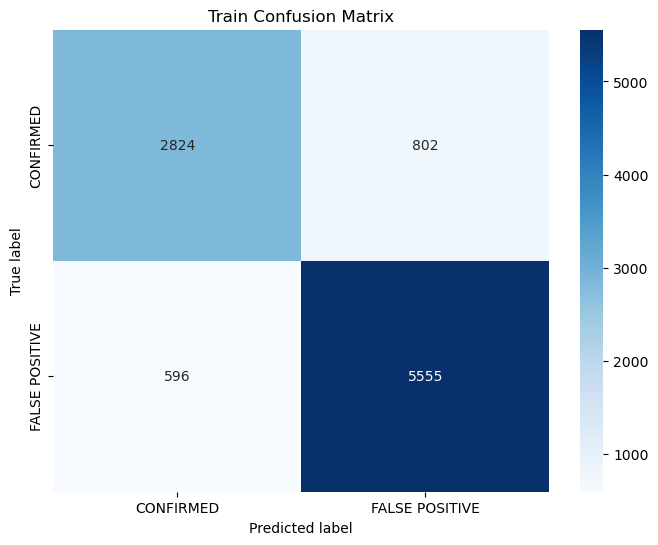

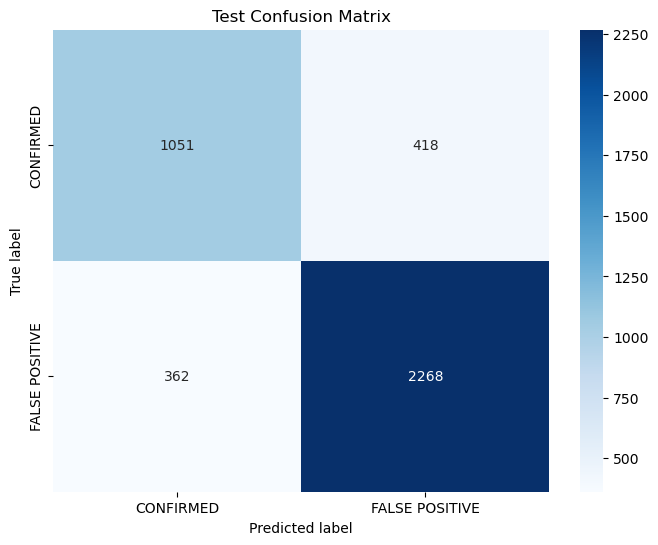

In [12]:

predicted, labels = predict(model, train_loader)
plot_confusion_matrix(labels, predicted, classes, title='Train Confusion Matrix')

predicted, labels = predict(model, test_loader)
plot_confusion_matrix(labels, predicted, classes, title='Test Confusion Matrix')


## Probar el modelo con los datos de CANDIDATOS

In [ ]:
global_avg = []
global_diff = []
local_avg = []
local_diff = []

for lc in tqdm(candidates, desc='Processing light curves'):
    global_avg.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_diff.append(lc.pliegue_par_global._light_curve.flux.value)
    local_avg.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_diff.append(lc.pliegue_par_local._light_curve.flux.value)

items = []
for i in tqdm(range(len(global_avg)), desc='Creating items'):
    item = {
        'global_avg': global_avg[i],
        'global_diff': global_diff[i],
        'local_avg': local_avg[i],
        'local_diff': local_diff[i],
        'label': 2       
    }
    items.append(item)

candidates_dataset = torch.utils.data.TensorDataset(torch.tensor([item['global_avg'] for item in items]),
                                                    torch.tensor([item['global_diff'] for item in items]),
                                                    torch.tensor([item['local_avg'] for item in items]),
                                                    torch.tensor([item['local_diff'] for item in items]),
                                                    torch.tensor([item['label'] for item in items]))
print("Tamaño del conjunto de candidatos:", len(candidates_dataset))

candidates_loader = DataLoader(candidates_dataset, batch_size=batch_size, shuffle=False)

Creating items: 100%|██████████| 4092/4092 [00:00<00:00, 1367686.03it/s]


Tamaño del conjunto de candidatos: 4092


In [14]:
predicted_candidates, _ = predict(model, candidates_loader)


In [15]:
# contar los positivos y negativos
n_positive = sum(predicted_candidates)
n_negative = len(predicted_candidates) - n_positive
print("Exoplanetas confirmados:", n_positive)
print("Falso positivo:", n_negative)

Exoplanetas confirmados: 2402
Falso positivo: 1374
